# Video Games Review: Analysis

In this project, I explore [Metacritic's video games reviews](https://www.metacritic.com/browse/games/score/metascore/all/all/filtered?page=0).


## Setup

In this section, I import all necessary libraries, setup the SQLite database, and then import the input `.csv` files in a format that allows manipulation by both `sqlite` and `pandas`:


In [44]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

sql_engine = create_engine("sqlite://", echo=False)
games_df = pd.read_csv("./input/games.csv")

In [45]:
def df_to_sql_table(sql_table_name: str, dataframe: pd.DataFrame) -> None:
    dataframe.to_sql(sql_table_name, sql_engine, if_exists="replace", index=False)
    print(
        f"""SQL table "{sql_table_name}" created/updated!

Please see below for a preview:"""
    )
    preview_sql_table(sql_table_name, sql_engine_name=sql_engine)


def preview_sql_table(
    sql_table_name: str,
    sql_engine_name,
    row_count=10,
) -> None:
    preview_sql_query = f"""SELECT * FROM {sql_table_name} LIMIT {row_count}"""
    display(pd.read_sql_query(preview_sql_query, sql_engine_name))


df_to_sql_table("games", games_df)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,tbd,tbd
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,tbd,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,tbd,4.0
3,!4RC4N01D! 2: Retro Edition,PC,"February 6, 2018","Everyone dreams of returning 2007, but no one ...",tbd,3.8
4,!4RC4N01D! 3: Cold Space,PC,"March 8, 2018",!4RC4N01D! returns! This time we have an accid...,tbd,3.0
5,!4RC4N01D! 4: KOHBEEP edition,PC,"March 30, 2018",The legendary Arkanoid of your childhood is ba...,tbd,3.0
6,!Anyway!,PC,"June 6, 2018",Do you like parkour? Dashing retro times? AnyW...,tbd,3.0
7,!Arre Unicornio!,PC,"March 18, 2022",Arre Unicornio! is an online multiplayer video...,tbd,tbd
8,!BurnToDie!,PC,"September 27, 2018","!BurnToDie! - Hardcore platformer, in which yo...",tbd,3.0
9,!Dead Pixels Adventure!,PC,"June 12, 2018",Dead Pixels Adventure! - A unique retro game w...,tbd,3.0


## Cleaning


### Missing Values


#### `tbd` Metascore and user score should be replaced with `None`

Metascore will be "tbd" if there are <4 reviews for that game. User score will be "tbd" if there are <7 reviews for that game.


In [46]:
df_score_replaced = games_df.copy()
score_columns = [sc for sc in games_df.columns if sc.endswith("score")]

for c in score_columns:
    df_score_replaced[c] = df_score_replaced[c].replace("tbd", np.NaN)

df_to_sql_table("games", df_score_replaced)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,None,None
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,None,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,None,4.0
3,!4RC4N01D! 2: Retro Edition,PC,"February 6, 2018","Everyone dreams of returning 2007, but no one ...",None,3.8
4,!4RC4N01D! 3: Cold Space,PC,"March 8, 2018",!4RC4N01D! returns! This time we have an accid...,None,3.0
5,!4RC4N01D! 4: KOHBEEP edition,PC,"March 30, 2018",The legendary Arkanoid of your childhood is ba...,None,3.0
6,!Anyway!,PC,"June 6, 2018",Do you like parkour? Dashing retro times? AnyW...,None,3.0
7,!Arre Unicornio!,PC,"March 18, 2022",Arre Unicornio! is an online multiplayer video...,None,None
8,!BurnToDie!,PC,"September 27, 2018","!BurnToDie! - Hardcore platformer, in which yo...",None,3.0
9,!Dead Pixels Adventure!,PC,"June 12, 2018",Dead Pixels Adventure! - A unique retro game w...,None,3.0


#### `summary`, `metascore` and `userscore` are difficult to impute 

In [56]:
def count_missing_values(sql_table_name: str, col: str):
    missing_values_count_query = f"""
SELECT SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) missing_values_count
FROM {sql_table_name}
    """
    missing_count_df = pd.read_sql_query(missing_values_count_query, sql_engine)
    count_of_missing_values_in_col = missing_count_df.missing_values_count.iloc[0]
    print(
        f"""The column "{col}" has {count_of_missing_values_in_col if count_of_missing_values_in_col else "no"} missing values."""
    )


for c in games_df.columns:
    count_missing_values("games", c)


The column "name" has no missing values.
The column "platform" has no missing values.
The column "release_date" has no missing values.
The column "summary" has 17715 missing values.
The column "metascore" has 112155 missing values.
The column "userscore" has 105986 missing values.


### Duplicates


In [49]:
# check duplicates for "name", "summary" columns, as the other attributes can be expected to have duplicates
# exclude null values using `WHERE` statement as these will duplicate
for col in ["name", "summary"]:
    dup_df = pd.read_sql_query(
        f"""
        SELECT {col}, COUNT(*) counts
        FROM games
        WHERE {col} NOT NULL
        GROUP BY 1
        HAVING counts > 1
        ORDER BY 2 DESC
        """,
        sql_engine,
    )
    if not dup_df.empty:
        display(col, dup_df)


'name'

,name,counts
0,Terraria,11
1,Marvel: Ultimate Alliance,10
2,Madden NFL 07,10
3,LEGO Jurassic World,10
4,FIFA Soccer 13,10
...,...,...
16787,1 vs. 100,2
16788,.projekt,2
16789,-KLAUS-,2
16790,"#Xmas, Super Puzzles Dream",2


'summary'

,summary,counts
0,This game is a classic puzzle game with severa...,26
1,This game is a classic memory game with severa...,20
2,Join BIG C on his exciting journey through the...,10
3,Help the beautiful girls to immerse themselves...,10
4,Harry Potter takes a dark turn in this third-p...,10
...,...,...
11410,"A retro, hardcore 2D arcade game, where every...",2
11411,A fantasy yuri visual novel filled with magic...,2
11412,A bone-chilling body-horror game with escape ...,2
11413,Nioh 2 – The Complete Edition (available o...,2


The `name` column has duplicates largely due to each row representing a game for a particular _platform_. Eg: if a game was released on PC, PS4 and PS5 -- each of these will have its own entry.

However, if there are games that also duplicate when the `name` and `platform` columns are grouped, the entry that has incorrect attributes should be removed.


In [50]:
pd.read_sql_query(
    """
    SELECT name,
        platform,
        COUNT(*) counts
    FROM games
    GROUP BY 1, 2
    HAVING counts > 1
    ORDER BY 3 DESC
    """,
    sql_engine,
)


,name,platform,counts
0,Sword and Fairy,PC,3
1,4 Elements,DS,2
2,8Doors: Arum's Afterlife Adventure,PC,2
3,A-Men,PlayStation 3,2
4,A.N.N.E,PC,2
...,...,...,...
149,Yatagarasu: Attack on Cataclysm,PC,2
150,Zombie Hazard,PC,2
151,thinkSMART,DS,2
152,thinkSMART Family,Wii,2


In [51]:
# find entries for above games (and their platform) which duplicates
# create "name_platform" helper column to identify unique name+platform pairs
dups_df = pd.read_sql_query(
    """
    WITH dups_name_platform AS (
        SELECT name, 
            platform,
            COUNT(*) counts
        FROM games
        GROUP BY 1, 2
        HAVING counts > 1
    )
    
    SELECT g.*,
        REPLACE(LOWER(name), ' ', '-') || '//' || REPLACE(LOWER(platform), ' ', '-') name_platform
    FROM games g
    JOIN dups_name_platform
    USING (name, platform)
    """,
    sql_engine,
)

dups_df


,name,platform,release_date,summary,metascore,userscore,name_platform
0,4 Elements,DS,"April 19, 2011",A somber fate has befallen the inhabitants of ...,None,None,4-elements//ds
1,4 Elements,DS,"February 12, 2015",The ancient kingdom is in trouble! The magic o...,None,None,4-elements//ds
2,8Doors: Arum's Afterlife Adventure,PC,"April 8, 2021",8Doors is a story-driven Metroidvania-style a...,None,6.3,8doors:-arum's-afterlife-adventure//pc
3,8Doors: Arum's Afterlife Adventure,PC,"August 19, 2021","""8Doors"" is a story-driven Metroidvania-style ...",None,None,8doors:-arum's-afterlife-adventure//pc
4,A-Men,PlayStation 3,"October 17, 2012","A-Men is played out at A-Cor, the world's bigg...",None,None,a-men//playstation-3
...,...,...,...,...,...,...,...
304,thinkSMART,DS,"December 15, 2009",This original brain training program helps you...,None,None,thinksmart//ds
305,thinkSMART Family,Wii,"December 1, 2009",This original brain training program helps you...,None,None,thinksmart-family//wii
306,thinkSMART Family,Wii,"June 22, 2010",thinkSMART Family is game designed to help you...,None,None,thinksmart-family//wii
307,tiny & Tall: Gleipnir,PC,"November 3, 2020",None,None,None,tiny-&-tall:-gleipnir//pc


Similarly, `summary` column duplicates due to each row referring to a game that, despite being released on different platforms, have the same game summary.


In [ ]:
merged_df.to_sql("games", engine, if_exists="replace", index=False)

pd.read_sql_query(
    """
    SELECT name,
        platform,
        summary,
        COUNT(*) counts
    FROM games
    WHERE summary NOT NULL
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
    """,
    engine,
)


## Analysis


### Metascore vs User Scores

There are up to two scores (assuming sufficient rating volumes) for each game:

- A game's **Metascore** is the [weighted average of critics' and publications' reviews](https://www.metacritic.com/about-metascores).
- A game's **user score** is the mean of users' scores.


#### Metascores and user scores have a **_low_**, **_positive_** correlation

The Pearson Correlation Coefficient is approx `+0.270`.

Unlike other SQL implementations (like PostgreSQL's `CORR()`), SQLite lacks built-in function to calculate the correlation coefficient. Thus, I implement the calculation manually using the formula:

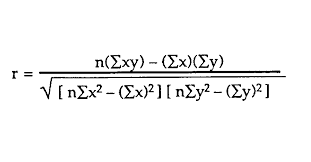


In [ ]:
pd.read_sql_query(
    """
    SELECT AVG( (user_score - avg_userscore) * (meta_score - avg_metascore) ) * AVG( (user_score - avg_userscore) * (meta_score - avg_metascore) ) / (var_userscore * var_metascore) AS pearson_corr_coeff 
    FROM games,
        (
            SELECT avg_userscore,
                avg_metascore,
                AVG((user_score - avg_userscore)*(user_score - avg_userscore)) as var_userscore,
                AVG((meta_score - avg_metascore)*(meta_score - avg_metascore)) as var_metascore
            FROM games,
                (
                    SELECT AVG(user_score) AS avg_userscore,
                        AVG(meta_score) AS avg_metascore
                    FROM games
                )
        )
    """,
    engine,
)


Visually, a scatterplot of all games' user score (x-axis) against Metascore (y-axis) validates this positive correlation.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.lmplot(
    data=merged_df,
    x="user_score",
    y="meta_score",
    scatter_kws={"color": "brown", "alpha": 0.08, "s": 20},
    line_kws={"color": "#595959"},
)
plt.show()


### Platforms


#### **Nintendo 64** and **PlayStation** have the highest rated games


In [ ]:
# transforming table to allow split boxplots
# normalise meta_score by having it out of 10 instead of 100

scores_stacked_df = pd.read_sql_query(
    """
    SELECT name,
        platform,
        meta_score / 10 score, 
        'meta' score_type,
        release_date
    FROM games
    WHERE score NOT NULL
    UNION ALL
    SELECT name,
        platform,
        user_score score,
        'user' score_type,
        release_date
    FROM games
    WHERE score NOT NULL
    ORDER BY platform
""",
    engine,
)
scores_stacked_df.head(3)


As SQLite does not have a built-in function nor efficient alternative to query the median values of each platform, we use `pandas`' `.median()` method:


In [ ]:
median_scores_df = (
    scores_stacked_df.groupby(["platform", "score_type"])
    .score.median()
    .reset_index()
    .rename(columns={"score": "median_score"})
)
median_scores_df


With the exception of Nintendo DS and Nintendo Wii, Metascores' distribution for each platform is similar to one another.

**Nintendo DS** and **Nintendo Wii** have lower, median and interquartile ranges of _Metascores_, though _users_ have reviewed games of other platforms lower.

Overall, the higher number of outliers for _user_ scores (as compared to Metascores) imply users tend to disagree with one another more than critics, which is expected. In particular, **PC** games have noticeably more low-end outliers, especially for user scores <4.


In [ ]:
plt.figure(figsize=(8, 10))
bp = sns.boxplot(
    data=scores_stacked_df,
    x="score",
    y="platform",
    hue="score_type",
    orient="h",
    palette=["orange", "#2998cd"],
)
plt.show()


#### Overall, users agree that **_handheld_** games are better

- Across all platform types, Metascores vary far more between games than user scores.
- Overall, users tend to rate **_handheld_** games the highest, followed by "hybrid" games (which refers to the Nintendo Switch, which can be played both as a _handheld_ platform and a home console).
- _PC_ games have the lowest median user scores, albeit only slightly compared to the other categories


In [ ]:
platform_type_df = pd.read_sql_query(
    """
    SELECT *,
        CASE
            WHEN platform IN ('3DS', 'DS', 'Game Boy Advance', 'PSP', 'PlayStation Vita') THEN 'handheld'
            WHEN platform IS 'Switch' THEN 'hybrid'
            WHEN platform IS 'PC' THEN 'pc'
            WHEN platform IS 'iOS' THEN 'mobile'
            ELSE 'home console'
        END platform_type
    FROM games
    """,
    engine,
)
platform_type_df.head(3)


In [ ]:
# transforming table in preparation for split boxplot
scores_stacked_df.to_sql("scores_unpivoted", engine, if_exists="replace", index=False)
scores_unpivoted_platform_cats = pd.read_sql_query(
    """
    SELECT *,
        CASE
            WHEN platform IN ('3DS', 'DS', 'Game Boy Advance', 'PSP', 'PlayStation Vita') THEN 'handheld'
            WHEN platform IS 'Switch' THEN 'hybrid'
            WHEN platform IS 'PC' THEN 'pc'
            WHEN platform IS 'iOS' THEN 'mobile'
            ELSE 'home console'
        END platform_type
    FROM scores_unpivoted
    """,
    engine,
)

plt.figure(figsize=(10, 8))
sns.violinplot(
    data=scores_unpivoted_platform_cats,
    x="platform_type",
    y="score",
    hue="score_type",
    palette=["orange", "#2998cd"],
    split=True,
)
plt.show()


### Older Games Tend to Be More Popular


As SQLite does not support month names ([StackOverflow](https://stackoverflow.com/questions/1181123/date-formatting-from-sqlite-query)) as is found in the `release_date` column, we use [`pandas.to_datetime()`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) method instead:


In [ ]:
merged_df["release_date"] = pd.to_datetime(merged_df.release_date, format="%B %d, %Y")
merged_df.head(2)


#### Games released in **_1995-1999_** inclusive tend to have higher user scores and Metascores...

Which aligns with our findings above that N64 (released 1996) and PS1 (released 1994) had the highest rated games

- As time goes by, newer-released games tend to attract _lower_ user scores (although there are exceptions, in the form of outliers)
- Games released in 2006-2008 inclusive attracted poorer Metascores


In [ ]:
sns.scatterplot(
    data=merged_df, x="release_date", y="meta_score", alpha=0.05, color="orange"
)
plt.show()


In [ ]:
sns.scatterplot(
    data=merged_df, x="release_date", y="user_score", alpha=0.05, color="#2998cd"
)
plt.show()


In [ ]:
scores_stacked_df["release_date"] = pd.to_datetime(
    scores_stacked_df.release_date, format="%B %d, %Y"
)

plt.figure(figsize=(10, 8))
sns.boxplot(
    data=scores_stacked_df,
    x=scores_stacked_df.release_date.dt.year,
    y="score",
    hue="score_type",
    palette=["orange", "#2998cd"],
)
plt.xticks(rotation=90)
plt.show()


Median scores (which are less sensitive to outliers compared to mean) confirm these findings:

1. Median user scores decline as the game is released more recently, reaching a historical low for games released in 2023
2. Median Metascores have stayed around `7.0` following a dip for games released 2006-2008 inclusive.


In [ ]:
scores_stacked_by_year = scores_stacked_df.copy().drop("platform", axis=1)
scores_stacked_by_year["release_year"] = scores_stacked_by_year.release_date.dt.year
median_scores_by_year = (
    scores_stacked_by_year.groupby(["release_year", "score_type"])
    .score.median()
    .reset_index()
    .rename(columns={"score": "median_score"})
)
# median_scores_by_year.head(5)


In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(
    data=median_scores_by_year,
    x="release_year",
    y="median_score",
    hue="score_type",
    palette=["orange", "#2998cd"],
    linewidth=3,
)
plt.show()
